# Recipients of subsidy to private day-care and day-care of own children by region

In this project we investigate the development in the popularity of private and at home day-care.

**$\large \color{lightblue}{{Imports}\:{and}\:{Set}\:{Magics}}$**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

from ipywidgets import interact


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


In the following we have identified the tables of interest, and the subject under which we find them. 

In [2]:
# Setup data loader with the langauge 'english'
Dst = pydst.Dst(lang='en') 

# Get a list of all subjects 
Dst.get_subjects() 

# Get all tables in subject '1' (people)
tables = Dst.get_tables(subjects=['1']) 

# Display only the tables in '1' containing 'Recipients of subsidy to private day-care and' in the text because we know that the table of interest contains this in its title 
display(tables[tables['text'].str.contains('Recipients of subsidy to private day-care and')])

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
137,DAGTIL4,Recipients of subsidy to private day-care and ...,Number,2022-03-30 08:00:00,2008,2021,True,"[region, grant type, affected , time]"


$\large 1.$ **$\large \color{lightblue}{Import}\:{and}\:{Arrange}\:{Data}$**


We import data from DAGTIL4 and BY2

DAGTIL4 contains information on the type of subsidity granted: "Subsidy for day-care of own children" or "Subsidy to parents who choose private day-care". Additionally, who the affected party is; the Children or the Family.

BY2 contains information on the number of peopel of a certain age within each Municipality and the gender. Furthermore, the size of the municipality. 

Both data sets have a Municipality dimension, and a year-time dimention. These we use, when merging the data sets. 

In [3]:
# Importing the data from DAGTIL4
Rec_vars = Dst.get_variables(table_id='DAGTIL4')
Rec_vars

# Make the Dataframe
variables_rec = {'OMRÅDE':['*'],'TILSKUDSART':['*'],'BERORT':['*'], 'TID':['*']}
rec_gen= Dst.get_data(table_id = 'DAGTIL4', variables=variables_rec)
rec_gen.sort_values(by=['TID', 'OMRÅDE'], inplace=True)

# On municipality and year level, sum the number of recipients of each subsidy type
rec_gen = rec_gen.groupby(['OMRÅDE', 'TID', 'BERORT','TILSKUDSART']).sum().reset_index()

# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Children' and TILSKUDSART = 'Subsidy for day-care of own children'
rec_gen['own_child'] = rec_gen[(rec_gen['BERORT'] == 'Children') & (rec_gen['TILSKUDSART'] == 'Subsidy for day-care of own children')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')
# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Children' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['pri_child'] = rec_gen[(rec_gen['BERORT'] == 'Children') & (rec_gen['TILSKUDSART'] == 'Subsidy to parents who choose private day-care')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')

# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Families' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['pri_fam'] = rec_gen[(rec_gen['BERORT'] == 'Families') & (rec_gen['TILSKUDSART'] == 'Subsidy to parents who choose private day-care')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')
# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Families' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['own_fam'] = rec_gen[(rec_gen['BERORT'] == 'Families') & (rec_gen['TILSKUDSART'] == 'Subsidy for day-care of own children')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')

# Replace NaN with 0
rec_gen = rec_gen.fillna(0)
# Replace .. with 0
rec_gen = rec_gen.replace('..', 0)

# drop the INDHOLD, BERORT and TILSKUDSART columns
rec_gen = rec_gen.drop(columns=['INDHOLD','BERORT', 'TILSKUDSART'])

# Convert the own_child, pri_child, pri_fam and own_fam columns to integers
rec_gen['own_child'] = rec_gen['own_child'].astype(int)
rec_gen['pri_child'] = rec_gen['pri_child'].astype(int)
rec_gen['pri_fam'] = rec_gen['pri_fam'].astype(int)
rec_gen['own_fam'] = rec_gen['own_fam'].astype(int)

# For each OMRÅDE AND TID, sum the 'own_child', 'pri_child', 'pri_fam' and 'own_fam' columns
rec_gen = rec_gen.groupby(['OMRÅDE', 'TID']).sum().reset_index()

# Rename the columns
rec_gen = rec_gen.rename(columns={'OMRÅDE':'Municipality', 'TID':'Year'})

# Show the Dataframe
rec_gen.head(5)

,Municipality,Year,own_child,pri_child,pri_fam,own_fam
0,Aabenraa,2008,14,23,20,14
1,Aabenraa,2009,13,17,15,11
2,Aabenraa,2010,11,38,36,10
3,Aabenraa,2011,7,78,75,7
4,Aabenraa,2012,10,86,86,10


In [4]:
# Importing the data from BY2
By_vars = Dst.get_variables(table_id='BY2')
By_vars

# Make the Dataframe
variables_by = {'KOMK':['*'],'BYST':['*'],'ALDER':['*'], 'Tid':['*']}
by_gen= Dst.get_data(table_id = 'BY2', variables=variables_by)
by_gen.sort_values(by=['TID', 'KOMK'], inplace=True)

# Rename the columns
by_gen = by_gen.rename(columns={'KOMK':'Municipality','ALDER':'Age', 'TID':'Year'})

# Remove non-numeric characters from the "Age" column (the observations in 'Age' are of the type "51 years" and not "51") 
by_gen['Age'] = by_gen['Age'].str.replace(' years?', '', regex=True).astype(int)

# Filter the dataset to select rows where Age is between 0 and 6 years
age_0_to_6 = by_gen[(by_gen['Age'] >= 0) & (by_gen['Age'] <= 6)]

# Group the data by Municipality and Year and sum the number of persons
grouped_data = age_0_to_6.groupby(['Municipality', 'Year'])['INDHOLD'].sum()

# Convert the "Age" column to string type
by_gen['Age'] = by_gen['Age'].astype(str)

# Remove non-numeric characters from the "Age" column
by_gen['Age'] = by_gen['Age'].str.replace(' years?', '', regex=True).astype(int)

# Filter the dataset to select rows where Age is between 0 and 6 years
age_0_to_6 = by_gen[(by_gen['Age'] >= 0) & (by_gen['Age'] <= 6)]

# Group the data by Municipality and Year and sum the number of persons
grouped_data = age_0_to_6.groupby(['Municipality', 'Year'])['INDHOLD'].sum().reset_index()
grouped_data = grouped_data.rename(columns={'INDHOLD': 'Residents aged 0-6 years'})

# Add a new column for the total number of residents
total_residents = by_gen.groupby(['Municipality', 'Year'])['INDHOLD'].sum().reset_index()
total_residents = total_residents.rename(columns={'INDHOLD': 'Total number of residents'})

# Merge the two dataframes
data2 = pd.merge(grouped_data, total_residents, on=['Municipality', 'Year'])

# Show the dataframe
data2.head(5)

,Municipality,Year,Residents aged 0-6 years,Total number of residents
0,Aabenraa,2010,2414,29913
1,Aabenraa,2011,2381,29795
2,Aabenraa,2012,2321,29704
3,Aabenraa,2013,2221,29536
4,Aabenraa,2014,2122,29386


$\large 2.$  **$\large \color{lightblue}{Merge}$** 

In [5]:
one2one = pd.merge(data2,rec_gen,on=['Municipality', 'Year'],how='inner') # Merge the two dataframes by Municipality and Year
# one2one

$\large 3.$  **$\large \color{lightpurple}{General}\:{Development}$** 

In order to explore the data, we construct both static and interactive plots. 

Below we display the development in the fraction of the total Danish population that is between 0 and 6 years old. This shows a clear negative trend (see Fig. 1).

However, Fig. 2 shows an increase in the proportion of 0-6 year who receive a subsidity for private daycare. 

C:\Users\Louise Boe Prahl\AppData\Local\Temp\ipykernel_25924\3902694215.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_one2one = one2one.groupby('Year').sum()


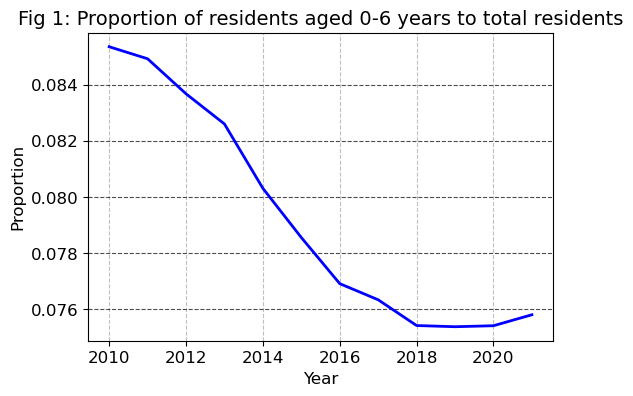

In [14]:
# Create a plot of proportion of residents aged 0-6 years to total residents

# Group the data by year and sum the columns for all municipalities
grouped_one2one = one2one.groupby('Year').sum()

# Calculate the proportion of residents aged 0-6 years to total residents
grouped_one2one['proportion'] = grouped_one2one['Residents aged 0-6 years'] / grouped_one2one['Total number of residents']

# Create a line plot of the proportion over time
fig, ax = plt.subplots(figsize=(6, 4))
grouped_one2one['proportion'].plot(kind='line', ax=ax, linewidth=2, color='blue')

# Set plot title and axis labels
ax.set_title('Fig 1: Proportion of residents aged 0-6 years to total residents', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)

# Customize tick labels and grid lines
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()

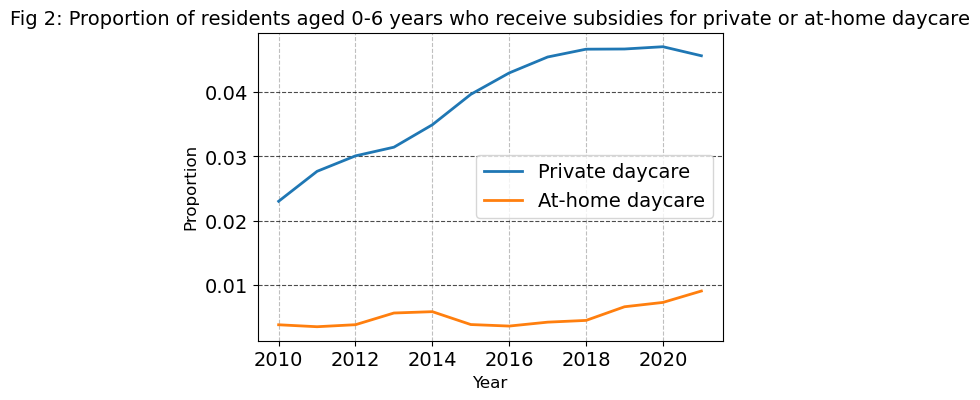

In [13]:
# Create a plot of proportion of residents aged 0-6 years who receives subsidies for private or at-home daycare to total residents aged 0-6 years

# Calculate the proportion of residents aged 0-6 years receiving either type of subsidy to total residents aged 0-6 years
grouped_one2one['proportion_private'] = grouped_one2one['pri_child'] / grouped_one2one['Residents aged 0-6 years']
grouped_one2one['proportion_home'] = grouped_one2one['own_child'] / grouped_one2one['Residents aged 0-6 years']

# Create a line plot of the proportion over time
fig, ax = plt.subplots(figsize=(6, 4))
grouped_one2one[['proportion_private', 'proportion_home']].plot(kind='line', ax=ax, linewidth=2)

# Set plot title and axis labels
ax.set_title('Fig 2: Proportion of residents aged 0-6 years who receive subsidies for private or at-home daycare', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)

# Customize tick labels and grid lines
ax.tick_params(axis='both', labelsize=14)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Customize legend
ax.legend(['Private daycare', 'At-home daycare'], fontsize=14)

plt.show()

$\large 4.$  **$\large \color{lightpurple}{Municipality}\:{Specific}\:{Development}$** 

It is not mandatory for the municipalities to offer the "At-home daycare subsidy". Therefore, we see that the proportion of "At-home daycare subsidies" vary a lot between the municipalities.  
We have chosen to zoom in on Copenhagen and Aarhus. Copenhagen introduced a trial for the "At-home daycare subsidy" up until 2016. This explains why the proportion on 0-6 year olds is positive in this period. However, Copenhagen chose not to extend the trial in 2016 causing the proportion to be zero from 2016. In 2020, they implemented the subsidy permanently. This is why we see an increase in the proportion from zero to approximately 1,25 percent in 2021. In 2021 we also see a small decrease in the proportion of "Private daycare subsidies" in Copenhagen. This can be due to the implementation of the "At-home daycare subsidy" but can also be caused by many other factors. 
In Aarhus, the proportion of "At-home daycare subsidies" is zero throughout the whole time period, as they haven't had a trial period nor introduced it permanently. Further, the proportion of "Private daycare subsidies" has increased from approximately 0,75 percent in 2010 to approximately 2,0 percent in 2021.

In [19]:
# Define function to update plot based on selected municipality
def update_plot(municipality):
    # Filter data to selected municipality
    subset = one2one[one2one['Municipality'] == municipality]
    
    # Group data by year and sum columns for selected municipality
    grouped = subset.groupby('Year').sum()
    
    # Calculate proportion of residents aged 0-6 years receiving either type of subsidy to total residents aged 0-6 years
    grouped['proportion_private'] = grouped['pri_child'] / grouped['Residents aged 0-6 years']
    grouped['proportion_home'] = grouped['own_child'] / grouped['Residents aged 0-6 years']
    
    # Create line plot of proportion over time for selected municipality
    fig, ax = plt.subplots(figsize=(6, 4))
    grouped[['proportion_private', 'proportion_home']].plot(kind='line', ax=ax, linewidth=2)
    
    # Set plot title and axis labels
    ax.set_title(f"Proportion of residents aged 0-6 years who receive subsidies for private or at-home daycare in {municipality}", fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Proportion', fontsize=12)
    
    # Customize tick labels and grid lines
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Customize legend
    ax.legend(['Private daycare', 'At-home daycare'], fontsize=14)
    
    plt.show()

# Create dropdown menu of municipality names
municipalities = sorted(one2one['Municipality'].unique())
dropdown = widgets.Dropdown(options=municipalities, value=municipalities[0], description='Municipality:')

# Display dropdown and plot
interact(update_plot, municipality=dropdown);

interactive(children=(Dropdown(description='Municipality:', options=('Aabenraa', 'Aalborg', 'Aarhus', 'Alberts…

$\large 5.$  **$\large \color{lightpurple}{Conclusion}$** 

Children in the day care age (0-6 years) take up a decreasing proportion of the total population. 
The private day care is becoming more popular. 

In [38]:
########################### This is unfinishied code ###########################

# # # Define function to update plot based on selected municipality
# for municipality in municipalities:
#     one2one['proportion_private'] = one2one['pri_child'] / one2one['Residents aged 0-6 years']
#     one2one['proportion_home'] = one2one['own_child'] / one2one['Residents aged 0-6 years']

# # create a copy of the one2one dataframe, and name it one2one2
# one2one2 = one2one.copy()

# # drop the "Residents aged 0-6 years" column, and the "Total number of residents" column
# one2one2 = one2one2.drop(columns=['Residents aged 0-6 years', 'Total number of residents'])

# # concacenate the "Municipality" and "Year" columns
# one2one2['Municipality_Year'] = one2one2['Municipality'] + '_' + one2one2['Year'].astype(str)

# # for each municipality, calculate the difference between the 2021 value and the 2010 value of the proportion of residents aged 0-6 years who receive subsidies for private or at-home daycare to total residents aged 0-6 years
# one2one2['change_private'] = one2one2.groupby('Municipality')['proportion_private'].diff()
# one2one2['change_home'] = one2one2.groupby('Municipality')['proportion_home'].diff()

# # if NaN, replace with 0
# one2one2['change_private'] = one2one2['change_private'].fillna(0)
# one2one2['change_home'] = one2one2['change_home'].fillna(0)

# # for each municipality, calculate the average value of "change_private" and "change_home"
# one2one2['avg_change_private'] = one2one2.groupby('Municipality')['change_private'].mean()
# one2one2['avg_change_home'] = one2one2.groupby('Municipality')['change_home'].mean()

# one2one2
# # # import matplotlib.pyplot as plt


,Municipality,Year,own_child,pri_child,pri_fam,own_fam,proportion_private,proportion_home,Municipality_Year,change_private,change_home,avg_change_private,avg_change_home
0,Aabenraa,2010,11,38,36,10,0.015742,0.004557,Aabenraa_2010,0.000000,0.000000,NaN,NaN
1,Aabenraa,2011,7,78,75,7,0.032759,0.002940,Aabenraa_2011,0.017018,-0.001617,NaN,NaN
2,Aabenraa,2012,10,86,86,10,0.037053,0.004308,Aabenraa_2012,0.004294,0.001369,NaN,NaN
3,Aabenraa,2013,1,120,113,1,0.054030,0.000450,Aabenraa_2013,0.016977,-0.003858,NaN,NaN
4,Aabenraa,2014,0,161,157,0,0.075872,0.000000,Aabenraa_2014,0.021842,-0.000450,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,Ærø,2017,0,18,18,0,0.124138,0.000000,Ærø_2017,0.030388,0.000000,NaN,NaN
1138,Ærø,2018,0,19,18,0,0.136691,0.000000,Ærø_2018,0.012553,0.000000,NaN,NaN
1139,Ærø,2019,0,19,19,0,0.142857,0.000000,Ærø_2019,0.006166,0.000000,NaN,NaN
1140,Ærø,2020,0,19,19,0,0.159664,0.000000,Ærø_2020,0.016807,0.000000,NaN,NaN
